## REFERÊNCIAS

Exercício modificado e baseado no original do **Canal Sandeco - https://github.com/sandeco/CanalSandeco**

____


IDEIA ORIGINAL: <br/>
Adam Rosembrock <br/>
pyimagesearch.com - 
https://www.pyimagesearch.com/2020/03/16/detecting-covid-19-in-x-ray-images-with-keras-tensorflow-and-deep-learning/




## ATENÇÃO

Os métodos e técnicas usados neste vídeo são apenas para fins educacionais. Esse não é um estudo cientificamente rigoroso, nem será publicado em uma revista científica´.

## AGENDA

Dentro do tutorial de hoje, você aprenderá como:

- Abrir uma base de imagens de raio-X  (open data) de pacientes com resultado POSITIVO para COVID-19 e imagens de pacientes com resultado NEGATIVO.


- Dividir o dataset de imagens em conjunto de teste e conjunto de treino 


- Aplicar a técnica de aumento de dados (Data Augmentation)



- Aplicar a técnica de transferência de inteligência entre redes neurais (Transfer Learning)


- Treinar uma Rede Neural Convolucional com o Tensorflow/Keras para detectar automaticamente o COVID-19 em imagens de raios-X 


- Avaliar os resultados sob uma perspectiva educacional

## importações de bibliotecas

In [1]:
from PIL import Image
from os import listdir
from os.path import isdir
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG19
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import optimizers

### Carregando uma imagem

In [2]:
def select_image(filename):
    # load image from file
    image = Image.open(filename)
    # convert to RGB, if needed
    image = image.convert('RGB')
    image = image.resize((150,150))
    # convert to array
    return np.asarray(image)

### Carregando uma classe

In [3]:
def load_classes(diretorio, classe, imagens, labels):
    # iterando arquivos
    
    if diretorio == ".direcory" or classe == ".directory":
        return imagens, labels
    
    for filename in listdir(diretorio):
        if filename == ".directory":
            continue
        
        path = diretorio + filename
        try:           
            imagens.append(select_image(path))
            labels.append(classe)
        except:
            print("Erro ao ler imagem {}".format(path))

    return imagens, labels

### Selecionando Dataset

In [4]:
def select_data_set(diretorio):

    imagens = list()
    labels = list()

    for subdir in listdir(diretorio):
        # path
        path = diretorio + subdir + '/'

        if not isdir(path):
            continue
        imagens, labels = load_classes(path, subdir, imagens, labels)

    return imagens, labels

### Carregando dataset Covid-19

In [10]:
covid_dataset = "/home/nicolas/dev/github/data-garage/python/covid19/analisando-imagens-covid19/dataset/"  #imagens médicas/dataset/
imagens, labels  = select_data_set(covid_dataset)
imagens = np.array(imagens) / 255.0  ## convertendo de lista para array
labels = np.array(labels)  ## convertendo de lista para array

In [11]:
labels.shape

(128,)

In [12]:
imagens.shape

(128, 150, 150, 3)

### Tratando classes - Labels

In [13]:
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

In [14]:
to_categorical(labels)

array([[[1., 0.],
        [0., 1.]],

       [[1., 0.],
        [0., 1.]],

       [[1., 0.],
        [0., 1.]],

       [[1., 0.],
        [0., 1.]],

       [[1., 0.],
        [0., 1.]],

       [[1., 0.],
        [0., 1.]],

       [[1., 0.],
        [0., 1.]],

       [[1., 0.],
        [0., 1.]],

       [[1., 0.],
        [0., 1.]],

       [[1., 0.],
        [0., 1.]],

       [[1., 0.],
        [0., 1.]],

       [[1., 0.],
        [0., 1.]],

       [[1., 0.],
        [0., 1.]],

       [[1., 0.],
        [0., 1.]],

       [[1., 0.],
        [0., 1.]],

       [[1., 0.],
        [0., 1.]],

       [[1., 0.],
        [0., 1.]],

       [[1., 0.],
        [0., 1.]],

       [[1., 0.],
        [0., 1.]],

       [[1., 0.],
        [0., 1.]],

       [[1., 0.],
        [0., 1.]],

       [[1., 0.],
        [0., 1.]],

       [[1., 0.],
        [0., 1.]],

       [[1., 0.],
        [0., 1.]],

       [[1., 0.],
        [0., 1.]],

       [[1., 0.],
        [0., 1.]],

       [[1.,

### Definindo hyperparametros

In [15]:
batch_size   = 32 #tamanho do lote (Lotes de X imagens)
input_shape  = (150, 150, 3) 
random_state = 42 #serve para que possamos reproduzir o experimento
alpha        = 1e-5 #Taxa de aprendizado
epoch        = 100 #treinar por 100 epocas

## CALLBACKS

Callback são classes que auxiliam o treinamento do modelo usando o Keras. As classes que usaremos são:

- ModelCheckpoint
- ReduceLROnPlateau
- EarlyStopping

In [16]:
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

#### ModelCheckpoint

ModelCheckpoint nos ajudará a salvar o modelo para cada época, para que possamos treinar nosso modelo e não nos preocuparmos com possíveis problemas que possam acontecer, como travamento da máquina.

- **filepath**: onde será salvo o modelo
- **monitor**: métrica a ser monitorada
- **verbose**: (1) mostra na barra de progresso (0) não
- **save_best_only**: Salvar somente o melhor modelo
- **mode**: como vamos monitorar o 'val_acc' o valor aqui vai ser 'max'. Queremos a máxima acurácia.


In [17]:
filepath="transferlearning_weights.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

#### ReduceLROnPlateau

Nos auxiliara a reduzir a taxa de aprendizado pelo fator (factor) caso não ocorra a mudança no loss.

- **monitor**: métrica a ser monitorada
- **factor**: fator de redução caso estejamos em um plator
- **min_delta**: valor mínimo da perda
- **patience**: só altere pelo fator após se repitir por 'patience' vezes.
- **verbose**: (1) mostra na barra de progresso (0) não


In [18]:
lr_reduce = ReduceLROnPlateau(monitor='val_acc', factor=0.1, min_delta=alpha, patience=5, verbose=1)

### Array de Callbacks

In [19]:
callbacks = [checkpoint, lr_reduce]

### Particionando dataset em teste e treino

In [20]:
(trainX, testX, trainY, testY) = train_test_split(imagens, labels, test_size=0.20, stratify=labels, random_state=random_state)

In [21]:
trainX.shape

(102, 150, 150, 3)

In [22]:
trainY.shape

(102, 2)

## DATA AUGMENTATION
Ter um grande conjunto de dados é crucial para o desempenho do modelo baseado em Deep Learning. Como nosso conjunto não é tão grande, podemos usar a técnica de 'Aumento de dados' para melhorar o desempenho do nosso modelo

In [23]:
train_datagen = ImageDataGenerator(
        rotation_range=20,
        zoom_range=0.2)

train_datagen.fit(trainX)

data_aug = train_datagen.flow(trainX, trainY, batch_size=batch_size)

## TRANSFER LEARNING

* **weights:** qual base de imagens de treino
* **include_top:** se deve incluir a camada totalmente conectada na parte superior da rede
* **input_shape:** formato da imagem

In [24]:
conv_base = VGG19(weights='imagenet', include_top=False, input_shape=input_shape)

In [26]:
conv_base.summary()

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

### Retreinando parte da VGG19

#### Ajuste fino

As camadas iniciais aprendem características muito gerais e à medida que descemos (deep) a rede, as camadas tendem a aprender padrões mais específicos para a tarefa em que está sendo treinada.

Assim, no ajuste fino, queremos manter intactas as camadas iniciais (ou congelá-las) e treinar novamente as camadas inferiores para que ela possa entender nossos padrões.

O ajuste fino ajuda em duas limitações:

* Nossa quantidade de dados necessária para o treinamento não é grande, porém podemos dar mais capacidade de entendimento a rede pré-treinada. Porém, não estamos retreinando toda a rede.
* Segundo, a parte que está sendo retreinada não é treinada do zero. Como os parâmetros que precisam ser treinados são menores, a quantidaade de tempo de processamento necessária também será menor.

In [27]:
conv_base.trainable = True
set_trainable = False

for layer in conv_base.layers:
  if layer.name == 'block5_conv1':
    set_trainable = True
  if set_trainable:
    layer.trainable = True
  else:
    layer.trainable = False

In [28]:
conv_base.summary()

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

## CRIANDO O MODELO COM A VGG19 COMO BASE

* **GlobalAvaregePooling2D:** Realizar pooling (redução de resolução(pela média global)
* **BatchNormalization:** Aumentar a estabilidade de uma rede neural aplicando normalizações em meio ao treinamento
* **Flatton:** analiar imagem pela camada densa
* **Dense:** Camada densa da rede neual/Relu: ativação para imagens
* **Dropout**: Regularização para melhorar a generalidade da rede neural

In [29]:
model = models.Sequential()
model.add(conv_base)
model.add(layers.GlobalAveragePooling2D())
model.add(layers.BatchNormalization())
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.6))
model.add(layers.Dense(2, activation='softmax'))

In [30]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Model)                (None, 4, 4, 512)         20024384  
_________________________________________________________________
global_average_pooling2d (Gl (None, 512)               0         
_________________________________________________________________
batch_normalization (BatchNo (None, 512)               2048      
_________________________________________________________________
flatten (Flatten)            (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 128)               65664     
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 2

## COMPILANDO O MODELO

* loss: binary cross entropy (loss = erro)

In [31]:
model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['acc'])

## TREINANDO O MODELO

***Obs: não treinar na hora da live***

In [32]:
history = model.fit_generator(
                              data_aug,
                              steps_per_epoch=len(trainX)// batch_size, # parte inteira da divisão
                              validation_data=(testX, testY),
                              validation_steps=len(testX) // batch_size,# parte inteira da divisão
                              callbacks=callbacks,
                              epochs=epoch)



Instructions for updating:
Please use Model.fit, which supports generators.
  ...
    to  
  ['...']
Train for 3 steps, validate on 26 samples
Epoch 1/100
2/3 [===================>..........] - ETA: 4s - loss: 1.3301 - acc: 0.5000 
Epoch 00001: val_acc improved from -inf to 0.50000, saving model to transferlearning_weights.hdf5
3/3 [==============================] - 20s 7s/step - loss: 1.0648 - acc: 0.5286 - val_loss: 2.2522 - val_acc: 0.5000
Epoch 2/100
2/3 [===================>..........] - ETA: 4s - loss: 0.3566 - acc: 0.8947 
Epoch 00002: val_acc did not improve from 0.50000
3/3 [==============================] - 22s 7s/step - loss: 0.3247 - acc: 0.8857 - val_loss: 7.6685 - val_acc: 0.5000
Epoch 3/100
2/3 [===================>..........] - ETA: 9s - loss: 0.2825 - acc: 0.8906 
Epoch 00003: val_acc did not improve from 0.50000
3/3 [==============================] - 27s 9s/step - loss: 0.4650 - acc: 0.8857 - val_loss: 7.6685 - val_acc: 0.5000
Epoch 4/100
2/3 [===================>....

# ANALISANDO DADOS

In [35]:
import matplotlib.pyplot as plt
%matplotlib inline

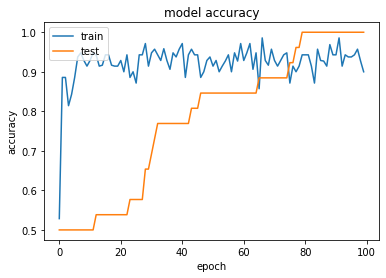

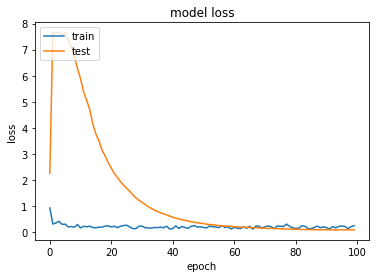

In [36]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Gerando matriz de confusão

In [37]:
from sklearn.metrics import confusion_matrix
pred = model.predict(testX)
pred = np.argmax(pred,axis = 1) 
y_true = np.argmax(testY,axis = 1)

Acurácia: 1.0000
Sensitividade: 1.0000
Especificidade: 1.0000


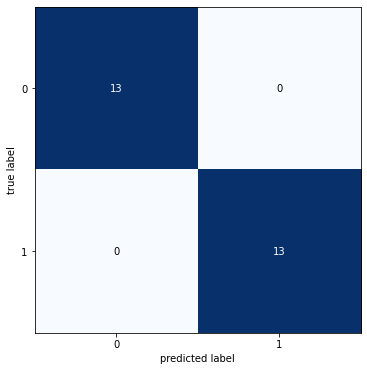

In [43]:
cm = confusion_matrix(y_true, pred)
total = sum(sum(cm))
acc = (cm[0, 0] + cm[1, 1]) / total
sensitivity = cm[0, 0] / (cm[0, 0] + cm[0, 1])
specificity = cm[1, 1] / (cm[1, 0] + cm[1, 1])

print("Acurácia: {:.4f}".format(acc))
print("Sensitividade: {:.4f}".format(sensitivity))
print("Especificidade: {:.4f}".format(specificity))

from mlxtend.plotting import plot_confusion_matrix
fig, ax = plot_confusion_matrix(conf_mat=cm ,  figsize=(6, 6))
plt.show()

### **Detector COVID-19 automático 96,15% de Acurácia.**

Também estamos obtendo 100% de sensibilidade e 92% de especificidade, o que implica que:

- Sensibilidade, capacidade indentificar caso positivo de COVID-19 com o modelo é de 100%.


- Especificidade, capacidade indentificar caso Não-Positivo de COVID-19 com o modelo é de 92,31%.


- Como mostra nosso gráfico de histórico de treinamento, nossa rede não está adaptando demais, apesar de ter dados de treinamento limitado